In [1]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, Embedding, Input, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import preprocessing, utils
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json, re, os

In [20]:
with open('/content/drive/MyDrive/Colab_Notebooks/Minor_Project/intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])
df

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
75,fact-28,[What do I do if I'm worried about my mental h...,[The most important thing is to talk to someon...
76,fact-29,[How do I know if I'm unwell?],"[If your beliefs , thoughts , feelings or beha..."
77,fact-30,[How can I maintain social connections? What i...,"[A lot of people are alone right now, but we d..."
78,fact-31,[What's the difference between anxiety and str...,[Stress and anxiety are often used interchange...


In [21]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
      for k in range(len(rspns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns[k])

df1 = pd.DataFrame.from_dict(dic)
df1 = df1.rename(columns={'tag': 'Tag', 'patterns': 'Questions', 'responses': 'Answers'})
df1

,Tag,Questions,Answers
0,greeting,Hi,Hello there. Tell me how are you feeling today?
1,greeting,Hi,Hi there. What brings you here today?
2,greeting,Hi,Hi there. How are you feeling today?
3,greeting,Hi,Great to see you. How do you feel currently?
4,greeting,Hi,Hello there. Glad to see you're back. What's g...
...,...,...,...
656,fact-29,How do I know if I'm unwell?,"If your beliefs , thoughts , feelings or behav..."
657,fact-30,How can I maintain social connections? What if...,"A lot of people are alone right now, but we do..."
658,fact-31,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...
659,fact-32,What's the difference between sadness and depr...,"Sadness is a normal reaction to a loss, disapp..."


In [22]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Minor_Project/mentalhealth.csv')
df2 = df2.rename(columns={'Question_ID': 'Tag', 'patterns': 'Questions', 'responses': 'Answers'})
df2

,Tag,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...
...,...,...,...
92,4373204,How do I know if I'm drinking too much?,Sorting out if you are drinking too much can b...
93,7807643,"If cannabis is dangerous, why are we legalizin...","Cannabis smoke, for example, contains cancer-c..."
94,4352464,How can I convince my kids not to use drugs?,You can't. But you can influence their capacit...
95,6521784,What is the legal status (and evidence) of CBD...,Cannabidiol or CBD is a naturally occurring co...


In [24]:
data = pd.concat([df1[['Questions','Answers']], df2[['Questions','Answers']]], axis=0, ignore_index=True)
data = data.sample(frac=1, random_state=42)
data = data.reset_index(drop=True)
data = data.head(400)
data

,Questions,Answers
0,hmmm that sounds like it could be useful to me.,Focus all your attention on your breathing. Co...
1,Thanks,Happy to help!
2,Nothing makes sense anymore,i first want to let you know that you are not ...
3,How can I maintain social connections? What if...,"A lot of people are alone right now, but we do..."
4,probably because of my exams,I see. Have you taken any approaches to not fe...
...,...,...
395,Why is mental health important?,Maintaining mental health is crucial to stabil...
396,I feel ok,That's geat to hear. I'm glad you're feeling t...
397,I don't want to talk about it.,I want to help you. I really do. But in order ...
398,How can I see a counsellor?,You can find directories of counsellors throug...


In [25]:
def clean_data(sentence):
    sentence = sentence.lower()

    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "can not", sentence)
    # remove all the punctuation
    sentence = re.sub(r"[\,.?:;_'!()\"-]", "", sentence)
    return sentence

In [26]:
print(data.iloc[13])

Questions    What should I do if I know someone who appears...
Answers      Although Pandora cannot substitute for profess...
Name: 13, dtype: object


In [27]:
for i in range(data.shape[0]):
  data['Questions'][i] = clean_data(str(data['Questions'][i]))
  data['Answers'][i] = clean_data(str(data['Answers'][i]))

data

,Questions,Answers
0,hmmm that sounds like it could be useful to me,focus all your attention on your breathing con...
1,thanks,happy to help
2,nothing makes sense anymore,i first want to let you know that you are not ...
3,how can i maintain social connections what if ...,a lot of people are alone right now but we don...
4,probably because of my exams,i see have you taken any approaches to not fee...
...,...,...
395,why is mental health important,maintaining mental health is crucial to stabil...
396,i feel ok,that is geat to hear i am glad you are feeling...
397,i dont want to talk about it,i want to help you i really do but in order fo...
398,how can i see a counsellor,you can find directories of counsellors throug...


In [28]:
encoder_inputs = data['Questions']
decoder_inputs = data['Answers']
len(encoder_inputs)

400

In [29]:
decoder_inputs = "start " + decoder_inputs + " end"
decoder_inputs

0      start focus all your attention on your breathi...
1                                start happy to help end
2      start i first want to let you know that you ar...
3      start a lot of people are alone right now but ...
4      start i see have you taken any approaches to n...
                             ...                        
395    start maintaining mental health is crucial to ...
396    start that is geat to hear i am glad you are f...
397    start i want to help you i really do but in or...
398    start you can find directories of counsellors ...
399         start hi there how are you feeling today end
Name: Answers, Length: 400, dtype: object

In [30]:
encoder_inputs_np = np.array(encoder_inputs)
decoder_inputs_np = np.array(decoder_inputs)

In [31]:
all_data = encoder_inputs + decoder_inputs

In [32]:
vocabulary = []
for sentence in all_data:
    sentence = sentence.split()
    for word in sentence:
        if word not in vocabulary: vocabulary.append(word)
tokenizer = Tokenizer(num_words=len(vocabulary))
tokenizer.fit_on_texts(all_data)

In [33]:
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [34]:
vocabulary_size = len(vocabulary) + 1
vocabulary_size

2519

In [35]:
#encoder_input_data
encoder_OH_input = tokenizer.texts_to_sequences(encoder_inputs) # a 2D neregular list
maxlen_OH_input_en = max(len(no) for no in encoder_OH_input)
encoder_input_data = pad_sequences(encoder_OH_input, maxlen=maxlen_OH_input_en, padding='post')
print(encoder_input_data.shape)
encoder_input_data

(400, 19)


array([[1459,   16,  549, ...,    0,    0,    0],
       [1052,    0,    0, ...,    0,    0,    0],
       [ 480,  481,  552, ...,    0,    0,    0],
       ...,
       [   8,   95,   82, ...,    0,    0,    0],
       [  33,   13,    8, ...,    0,    0,    0],
       [  10,  340,   46, ...,    0,    0,    0]], dtype=int32)

In [36]:
# decoder_input_data
decoder_OH_input = tokenizer.texts_to_sequences(decoder_inputs)
maxlen_OH_input_dec = max(len(no) for no in decoder_OH_input) # 60
decoder_input_data = pad_sequences(decoder_OH_input, maxlen=maxlen_OH_input_dec, padding='post')
print(decoder_input_data.shape)
decoder_input_data

(400, 1450)


array([[160, 274,  89, ...,   0,   0,   0],
       [160, 551,   1, ...,   0,   0,   0],
       [160,   8, 150, ...,   0,   0,   0],
       ...,
       [160,   8,  82, ...,   0,   0,   0],
       [160,   2,  13, ...,   0,   0,   0],
       [160, 217,  46, ...,   0,   0,   0]], dtype=int32)

In [37]:
# decoder_output_data
decoder_OH_output = tokenizer.texts_to_sequences(decoder_inputs)
# I am removing the START from the answers (the word from the beginning because it isn't required when delivering the answers)
for i in range(len(decoder_OH_output)):
    decoder_OH_output[i] = decoder_OH_output[i][1:]
decoder_output_d = pad_sequences(decoder_OH_output, maxlen=maxlen_OH_input_dec, padding='post')
decoder_output_data = to_categorical(decoder_output_d, vocabulary_size)
print(decoder_output_data.shape)
decoder_output_data

(400, 1450, 2519)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [38]:
### ENCODER - DECODER MODEL

# Create the input layer and process it.
encoder_in = Input(shape=(encoder_input_data.shape[1],), dtype='int32')
encoder_embedding = Embedding(input_dim=vocabulary_size, output_dim=50, mask_zero=True)(encoder_in)
encoder_out, state_h, state_c = LSTM(units=300, return_state=True)(encoder_embedding)

# Discard the outputs of the encoder, but keep the states
encoder_states = [state_h, state_c]

# Define the decoder: using the encoder states
# For decoder_out: return_sequences=True =>   All Hidden States (Hidden State of ALL the time steps), in this case a 3D output
decoder_in = Input(shape=(decoder_input_data.shape[1], ), dtype='int32')
decoder_embedding = Embedding(input_dim=vocabulary_size, output_dim=50, mask_zero=True)(decoder_in)
decoder_out, _, _ = LSTM(units=300, return_state=True, return_sequences=True)(decoder_embedding, initial_state=encoder_states)

output = Dense(vocabulary_size, activation='softmax')(decoder_out)

In [39]:
# Compile the model
model = Model([encoder_in, decoder_in], output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 19)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1450)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 19, 50)               125950    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1450, 50)             125950    ['input_4[0][0]']             
                                                                                            

In [ ]:
BATCH_SIZE = 8
EPOCHS = 200

callbacks_list = [ EarlyStopping(monitor='accuracy', patience=5), ]

history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list, validation_split = 0.2)
# model_name = 'Model.h5'
# model_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Minor_Project/', model_name)
# model.save(model_path)

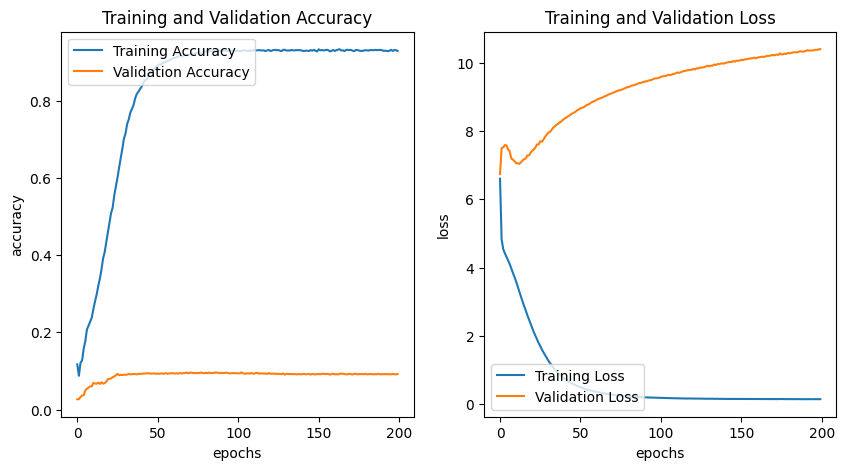

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure(figsize=(10,5))

# Loss Plotting
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

# Accuracy plotting
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/Colab_Notebooks/Minor_Project/Model.h5')

In [ ]:
encoder_in = model.input[0]
encoder_out, state_h, state_c = model.get_layer('lstm').output
encoder_states = [state_h, state_c]

In [ ]:
decoder_in = model.input[1]
decoder_embedding = model.get_layer('embedding_1').output
decoder_lstm= model.get_layer('lstm_1')
decoder_dense = model.get_layer('dense')

# decoder_in = model.input[1]
# decoder_embedding = model.layers[3]
# decoder_lstm = model.layers[5]
# decoder_dense = model.layers[6]

In [ ]:
def make_inference_models():
    encoder_model = Model(encoder_in, encoder_states)

    decoder_state_in_h = Input(shape=(300, ), name='anotherInput1')
    decoder_state_in_c = Input(shape=(300, ), name='anotherInput2')

    decoder_states_in = [decoder_state_in_h, decoder_state_in_c]

    decoder_out, decoder_state_out_h, decoder_state_out_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_in)
    decoder_states_out = [decoder_state_out_h, decoder_state_out_c]

    output = decoder_dense(decoder_out)

    decoder_model = Model([decoder_in] + decoder_states_in, [output] + decoder_states_out)

    return encoder_model, decoder_model

In [ ]:
def input_to_tokens(sentence):
    sentence = clean_data(sentence)

    words = sentence.split()
    tokens_list=[]
    for w in words:
        result = tokenizer.word_index.get(w, '')
        if result != '' : tokens_list.append(result)

    input_question = pad_sequences([tokens_list], maxlen=maxlen_OH_input_en, padding='post')
    return input_question

In [ ]:
@tf.function
def predict_with_dec_model(dec_model, empty_target_sequence, c, h):
    return dec_model([empty_target_sequence, c, h])

#Method that will create a response using seq2seq model we built
def generate_response(user_input):
    input_sequence = input_to_tokens(user_input)

    # Move the call to enc_model.predict() outside of the tf.function
    predictions = enc_model.predict(input_sequence, verbose=0)  # Set verbose=0 to suppress progress output

    empty_target_sequence = np.zeros((1, 1))
    empty_target_sequence[0, 0] = tokenizer.word_index['end']

    decoded_answer = ''
    ok = True
    while ok:
        # feed the one-word target sequence + predictions from the enc_model
        dec_out, c, h = predict_with_dec_model(dec_model, empty_target_sequence, *predictions)

        # take the index of the word with the highest probability
        new_word_index = np.argmax(dec_out[0, -1, :])
        new_word = None

        # append the new word to the decoded_answer
        for word, index in tokenizer.word_index.items():
            if new_word_index == index:
                if word != 'end':
                    decoded_answer += '{} '.format(word)
                new_word = word

        # predicting the next word or ending the loop and giving the final result
        if new_word != 'end' and len(decoded_answer.split()) <= maxlen_OH_input_dec:
            empty_target_sequence = np.zeros((1, 1))
            empty_target_sequence[0, 0] = new_word_index
            predictions = [c, h]
        else:
            ok = False

    return decoded_answer

In [ ]:
enc_model, dec_model = make_inference_models()

In [ ]:
exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")

#Method to handle the conversation
def chat(reply):
  while not make_exit(reply):
    reply = input("AI: " + generate_response(reply)+"\n")

#Method to check for exit commands
def make_exit(reply):
  for exit_command in exit_commands:
    if exit_command in reply:
      print("AI: Ok, have a great day!")
      return True
  return False

In [ ]:
#Method to start the conversation
def start_chat():
  print("AI: Hi I am an AI ChatBot. Share your thoughts")
  user_response = input()
  chat(user_response)

In [ ]:
start_chat()

AI: Hi I am an AI ChatBot. Share your thoughts
Good morning
AI: didnt morning good evening how has your day been 
i am going to start my day
AI: the deep breath and gather your thoughts go take a walk if possible stay hydrated 
how much water
AI: good elucidate your thoughts 
hmmm
AI: elucidate talk good night get some proper in your feelings and change your way of thinking by being open to trying to change 
stop
AI: Ok, have a great day!
